# 3. Capstone Pre-processing Training & Data Development

In [1]:
# Libraries imported for this notebook.

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from matplotlib.dates import MonthLocator
import numpy as np
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
# Read Lake_Fictitious_AquaRealTime_Data_EDA into a dataframe, formatted dates, and indexed dates.

df = pd.read_excel('Lake_Fictitious_AquaRealTime_Data_EDA.xlsx', parse_dates=True, index_col=[0])

In [3]:
# Looked at shape

df.shape

(53850, 5)

## Grouping Rows

I will now calculate the mean values of metrics over a one day period so I can use these data for my model. I'm doing this because I want to be able to forcast multiple days in advance and the data is currently by the half hour. Typically, time series data granularity, or unit, should be the same as the prediction unit, in this case, days. This step can also sometime normalize data and make non-stationary data into stationary data.

In [4]:
# Grouped rows by day.

# Create a copy of the original DataFrame
mean_df = df.copy()

# Extract date from timestamps and set as index
mean_df.index = pd.to_datetime(mean_df.index).date

# Group by date and calculate mean
mean_df = mean_df.groupby(mean_df.index).mean()

# Print the summary DataFrame
mean_df

,phycocyanin,light,waterTemp,turbidity,chlorA
2021-01-27,29.030577,178.484613,12.553846,22.200385,406.140191
2021-01-28,32.204582,133.795139,11.198958,23.549844,510.559024
2021-01-29,32.419998,118.664582,11.183108,23.722331,484.313971
2021-01-30,32.419998,140.362499,11.247973,23.770979,456.055591
2021-01-31,29.996562,134.059028,11.950169,22.993095,422.760014
...,...,...,...,...,...
2024-02-19,8.405208,148.206250,15.650000,2.264792,85.007083
2024-02-20,9.267292,101.362501,15.100000,2.563333,89.794999
2024-02-21,9.417917,172.979168,15.237500,2.962500,92.104791
2024-02-22,11.089583,246.960419,15.189583,3.552292,103.188958


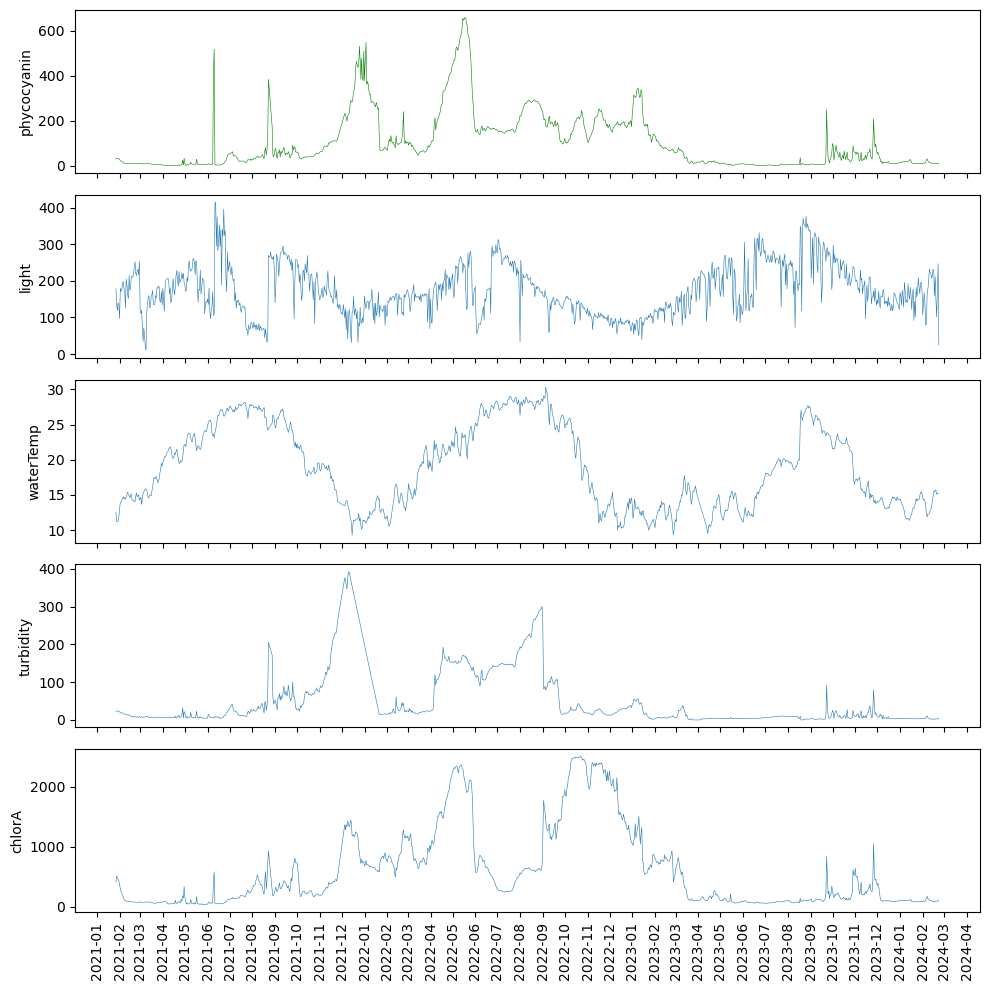

In [5]:
# Plotted summerized row data.

fig, axes = plt.subplots(nrows=len(mean_df.columns), ncols=1, figsize=(10, 2 * len(mean_df.columns)), sharex=True)
for i, column in enumerate(mean_df.columns):
    if column == 'phycocyanin':
        axes[i].plot(mean_df.index, mean_df[column], linewidth=0.4, color='green')
    else:
        axes[i].plot(mean_df.index, mean_df[column], linewidth=0.4)
    axes[i].set_ylabel(column)
    axes[i].xaxis.set_major_locator(MonthLocator())
    axes[i].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

## Feature Engineering

### Normalize

In [6]:
# Performed Shapiro-Wilk test to see is metrics had a normal distribution.

for column in mean_df.columns:
    stat, p_value = shapiro(mean_df[column])
    print(f"Shapiro-Wilk test for {column}: Statistic={stat}, p-value={p_value}")

Shapiro-Wilk test for phycocyanin: Statistic=0.7793733477592468, p-value=2.1736244044075206e-36
Shapiro-Wilk test for light: Statistic=0.98431795835495, p-value=1.2263844384463596e-09
Shapiro-Wilk test for waterTemp: Statistic=0.9253000020980835, p-value=3.4837713161693774e-23
Shapiro-Wilk test for turbidity: Statistic=0.6804240345954895, p-value=1.2600475791208755e-41
Shapiro-Wilk test for chlorA: Statistic=0.7806943655014038, p-value=2.6244726568086316e-36


The p-values inproved but the data are still far from normal. Therefore, I will will calulate the natural log of the data which is often used for normalizing data, especially when the data has a heavily right-skewed distribution. Taking the natural logarithm can compress large values, making the distribution more symmetric and closer to a normal distribution.

In [7]:
# Calculated the natural logarithm of all columns. 

# Added a small constant to avoid logarithm of zero and calculated the nat log
log_columns = mean_df.apply(lambda x: np.log(x + 1e-10))

# Adding prefix 'nl_'
log_columns.columns = ['nl_' + col for col in log_columns.columns]

# Add the nat log columns to mean_df
mean_df = pd.concat([mean_df, log_columns], axis=1)

In [8]:
# Reperformed Shapiro-Wilk test to see is metrics had a normal distribution after normalization.

for column in mean_df.columns:
    stat, p_value = shapiro(mean_df[column])
    print(f"Shapiro-Wilk test for {column}: Statistic={stat}, p-value={p_value}")

Shapiro-Wilk test for phycocyanin: Statistic=0.7793733477592468, p-value=2.1736244044075206e-36
Shapiro-Wilk test for light: Statistic=0.98431795835495, p-value=1.2263844384463596e-09
Shapiro-Wilk test for waterTemp: Statistic=0.9253000020980835, p-value=3.4837713161693774e-23
Shapiro-Wilk test for turbidity: Statistic=0.6804240345954895, p-value=1.2600475791208755e-41
Shapiro-Wilk test for chlorA: Statistic=0.7806943655014038, p-value=2.6244726568086316e-36
Shapiro-Wilk test for nl_phycocyanin: Statistic=0.4717855453491211, p-value=0.0
Shapiro-Wilk test for nl_light: Statistic=0.9605578780174255, p-value=7.32281886643963e-17
Shapiro-Wilk test for nl_waterTemp: Statistic=0.9385553002357483, p-value=3.899921520259544e-21
Shapiro-Wilk test for nl_turbidity: Statistic=0.5193285346031189, p-value=0.0
Shapiro-Wilk test for nl_chlorA: Statistic=0.9404435157775879, p-value=8.110606880278305e-21


I'll check again to see in the natutal log values are stationary.

In [9]:
# Redefined function to run KPSS test.

def kpss_test(timeseries, column_name):
    print('Results of KPSS Test for column "{}":'.format(column_name))
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic', 'p-value', '#Lags Used'])
    for key, value in kpsstest[3].items():
        kpss_output['Critical Value (%s)' % key] = value
    print(kpss_output)
    print()

In [10]:
# Ran KPSS for natutal logged metrics.

for column in mean_df.columns:
    if 'nl_' in column:
        kpss_test(mean_df[column], column)

Results of KPSS Test for column "nl_phycocyanin":
Test Statistic            0.524956
p-value                   0.036046
#Lags Used               19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Results of KPSS Test for column "nl_light":
Test Statistic            0.297651
p-value                   0.100000
#Lags Used               19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Results of KPSS Test for column "nl_waterTemp":
Test Statistic            0.646226
p-value                   0.018434
#Lags Used               20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Results of KPSS Test for column "nl_turbidity":
Test Statistic            1

/var/folders/77/lhc9l51s19q1rxd2jv1wfxf40000gn/T/ipykernel_43335/651794571.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags="auto")
/var/folders/77/lhc9l51s19q1rxd2jv1wfxf40000gn/T/ipykernel_43335/651794571.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags="auto")
/var/folders/77/lhc9l51s19q1rxd2jv1wfxf40000gn/T/ipykernel_43335/651794571.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags="auto")


The p-value for 'nl_light' is >0.10 which is more than the significance level of 0.05. Therefore, I fail to reject the null hypothesis of stationarity for this metric. It is likely stationary according to the KPSS test. 'nl_phycocyanin', 'nl_waterTemp', 'nl_turbidity', and 'nl_chlorA' however, all have p-value <0.01, which idicates that they are non-stationary.

In [11]:
# Redefined function to run ADF test.

def adf_test(timeseries, column_name):
    print('Results of ADF Test for column "{}":'.format(column_name))
    adftest = adfuller(timeseries, autolag='AIC')
    adf_output = pd.Series(adftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in adftest[4].items():
        adf_output['Critical Value (%s)' % key] = value
    print(adf_output)
    print()

In [12]:
# Ran ADF for natural logged metrics.

for column in mean_df.columns:
    if 'nl_' in column:
        adf_test(mean_df[column], column)

Results of ADF Test for column "nl_phycocyanin":
Test Statistic                   -3.839789
p-value                           0.002525
#Lags Used                       16.000000
Number of Observations Used    1106.000000
Critical Value (1%)              -3.436276
Critical Value (5%)              -2.864157
Critical Value (10%)             -2.568163
dtype: float64

Results of ADF Test for column "nl_light":
Test Statistic                   -5.292293
p-value                           0.000006
#Lags Used                        4.000000
Number of Observations Used    1118.000000
Critical Value (1%)              -3.436213
Critical Value (5%)              -2.864129
Critical Value (10%)             -2.568148
dtype: float64

Results of ADF Test for column "nl_waterTemp":
Test Statistic                   -2.553253
p-value                           0.103049
#Lags Used                        2.000000
Number of Observations Used    1120.000000
Critical Value (1%)              -3.436202
Critical Val

The p-values for 'nl_phycocyanin', 'nl_light', 'nl_turbidity' are less <0.05, indicating strong evidence against the presence of a unit root. Thus, I reject the null hypothesis for these variables, suggesting that they are likely stationary according to the ADF test. 'nl_waterTemp' and 'nl_chlorA', however, have p-values >0.05, which idicates that they are non-stationary.

Together, the KPSS and ADF tests indicate that 'nl_light' is stationary and 'nl_waterTemp' and 'nl_chlorA' metrics are non-stationary. As for 'nl_phycocyanin' and 'nl_turbidity', the KPSS test indicates that the metric is non-stationary while the ADF test indicates that it is stationary. This apparent contradiction indicates that 'nl_phycocyanin' is difference stationary. As a result, all metrics but 'nl_light' will need to be detrended.

### Temporal

#### Detrending

'nl_phycocyanin', 'nl_waterTemp', 'nl_turbidity', and 'nl_chlorA' need to be detrended so I performed differencing to compute the differences between consecutive data points. This technique is often performed for time series models and can transform a non-stationary time series into a stationary one and remove trends and seasonality. Overall, differencing can be beneficial because it stabilizes the mean and variance of the data, making it easier to identify underlying patterns and relationships.

In [13]:
# Added first-order differenced features to mean_df for all nl_metrics but nl_light.

# Filtered for columns to perform differencing
columns_to_difference = mean_df.columns[mean_df.columns.str.contains('nl_') & (mean_df.columns != 'nl_light')]

# Performed first-order differencing on specified columns
first_differences = mean_df[columns_to_difference].diff().add_prefix('dif_')

# Concatenated the results with the original DataFrame
mean_df = pd.concat([mean_df, first_differences], axis=1).dropna()

In [14]:
# Looked at just 'phycocyanin' to check differencing calculations.

selected_columns = ['phycocyanin','nl_phycocyanin', 'dif_nl_phycocyanin']
new_df = mean_df.loc[:, selected_columns]
new_df.head(10)

,phycocyanin,nl_phycocyanin,dif_nl_phycocyanin
2021-01-28,32.204582,3.472109,0.103759
2021-01-29,32.419998,3.478775,0.006667
2021-01-30,32.419998,3.478775,0.000000
2021-01-31,29.996562,3.401083,-0.077693
2021-02-01,28.018646,3.332870,-0.068213
2021-02-02,20.748334,3.032466,-0.300404
2021-02-03,18.696979,2.928362,-0.104104
2021-02-04,16.626042,2.810970,-0.117392
2021-02-05,15.093646,2.714274,-0.096696
2021-02-06,13.203854,2.580509,-0.133765


In future steps, I will be using the differenced data and light in models. For ease of selecting features, I will copy the 'light' column and add 'dif_' to the beginning.

In [15]:
# Duplicated the 'nl_light' column and add 'dif_' to the beginning.

mean_df['dif_nl_light'] = mean_df['nl_light']

In [16]:
# Checked feature names

for column_title in mean_df.columns:
    print(column_title)

phycocyanin
light
waterTemp
turbidity
chlorA
nl_phycocyanin
nl_light
nl_waterTemp
nl_turbidity
nl_chlorA
dif_nl_phycocyanin
dif_nl_waterTemp
dif_nl_turbidity
dif_nl_chlorA
dif_nl_light


Now I need to run the KPSS and ADF tests on the natural logged and differenced metrics to see if my detrending was effective.

In [17]:
# Ran KPSS for first-order differenced natural logged metrics.

for column in mean_df.columns:
    if 'dif_nl_' in column:
        kpss_test(mean_df[column], column)

Results of KPSS Test for column "dif_nl_phycocyanin":
Test Statistic            0.018277
p-value                   0.100000
#Lags Used               30.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Results of KPSS Test for column "dif_nl_waterTemp":
Test Statistic           0.089576
p-value                  0.100000
#Lags Used               3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

Results of KPSS Test for column "dif_nl_turbidity":
Test Statistic            0.009094
p-value                   0.100000
#Lags Used               13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Results of KPSS Test for column "dif_nl_chlorA":
Test Statistic   

/var/folders/77/lhc9l51s19q1rxd2jv1wfxf40000gn/T/ipykernel_43335/651794571.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags="auto")
/var/folders/77/lhc9l51s19q1rxd2jv1wfxf40000gn/T/ipykernel_43335/651794571.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags="auto")
/var/folders/77/lhc9l51s19q1rxd2jv1wfxf40000gn/T/ipykernel_43335/651794571.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags="auto")
/var/folders/77/lhc9l51s19q1rxd2jv1wfxf40000gn/T/ipykernel_43335/651794571.p

The p-value for all metrics are >0.10 which is more than the significance level of 0.05. Therefore, I fail to reject the null hypothesis of stationarity for all metrics. They are all likely stationary according to the KPSS test.

In [18]:
# Ran ADF for first-order differenced natural logged metrics.

for column in mean_df.columns:
    if 'dif_nl_' in column:
        adf_test(mean_df[column], column)

Results of ADF Test for column "dif_nl_phycocyanin":
Test Statistic                -8.368693e+00
p-value                        2.698883e-13
#Lags Used                     2.200000e+01
Number of Observations Used    1.099000e+03
Critical Value (1%)           -3.436314e+00
Critical Value (5%)           -2.864173e+00
Critical Value (10%)          -2.568172e+00
dtype: float64

Results of ADF Test for column "dif_nl_waterTemp":
Test Statistic                  -22.853962
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1120.000000
Critical Value (1%)              -3.436202
Critical Value (5%)              -2.864124
Critical Value (10%)             -2.568146
dtype: float64

Results of ADF Test for column "dif_nl_turbidity":
Test Statistic                -1.082642e+01
p-value                        1.752219e-19
#Lags Used                     1.700000e+01
Number of Observations Used    1.104000e+03
Critical Value (1%)         

The p-values for all metrics are less than 0.05, indicating strong evidence against the presence of a unit root. Thus, I reject the null hypothesis for these variables, suggesting that they are likely stationary according to the ADF test.

Together, the KPSS and ADF tests indicate that all first-order differenced metrics and 'light' are stationary. I do not need to perform second-order differencing.

#### Lag Features

I created lagged versions of the original data and differenced natural logged metrics of 1 through 20 time periods (days). Blue-green algae usually takes a few days to grow after stimultion so this should be enough lags. However, sometimes it takes longer than this. I can increase the number later if needed.

In [19]:
# Lagged all features by 1 through 20 time periods.

lagged_columns = []

lagged_df = pd.DataFrame()

for lag in range(1, 21):
    relevant_columns = [col for col in mean_df.columns]
    lagged_columns.extend([f'{var}_lag_{lag:02d}' for var in relevant_columns])
    lagged_data = {f"{var}_lag_{lag:02d}": mean_df[var].shift(lag) for var in relevant_columns}
    lagged_df = pd.concat([lagged_df, pd.DataFrame(lagged_data)], axis=1)

mean_df = pd.concat([mean_df, lagged_df], axis=1)

In [20]:
# Dropped rows containng NaN as a result of lagged features.

mean_df.dropna(inplace=True)

In [21]:
# Added 'lag_00' to names for clearity.

mean_df.rename(columns={col: col + '_lag_00' for col in mean_df.columns[0:15]}, inplace=True)

In [22]:
# Printed list of column titles to check results of lagging.

for column_title in mean_df.columns:
    print(column_title)

phycocyanin_lag_00
light_lag_00
waterTemp_lag_00
turbidity_lag_00
chlorA_lag_00
nl_phycocyanin_lag_00
nl_light_lag_00
nl_waterTemp_lag_00
nl_turbidity_lag_00
nl_chlorA_lag_00
dif_nl_phycocyanin_lag_00
dif_nl_waterTemp_lag_00
dif_nl_turbidity_lag_00
dif_nl_chlorA_lag_00
dif_nl_light_lag_00
phycocyanin_lag_01
light_lag_01
waterTemp_lag_01
turbidity_lag_01
chlorA_lag_01
nl_phycocyanin_lag_01
nl_light_lag_01
nl_waterTemp_lag_01
nl_turbidity_lag_01
nl_chlorA_lag_01
dif_nl_phycocyanin_lag_01
dif_nl_waterTemp_lag_01
dif_nl_turbidity_lag_01
dif_nl_chlorA_lag_01
dif_nl_light_lag_01
phycocyanin_lag_02
light_lag_02
waterTemp_lag_02
turbidity_lag_02
chlorA_lag_02
nl_phycocyanin_lag_02
nl_light_lag_02
nl_waterTemp_lag_02
nl_turbidity_lag_02
nl_chlorA_lag_02
dif_nl_phycocyanin_lag_02
dif_nl_waterTemp_lag_02
dif_nl_turbidity_lag_02
dif_nl_chlorA_lag_02
dif_nl_light_lag_02
phycocyanin_lag_03
light_lag_03
waterTemp_lag_03
turbidity_lag_03
chlorA_lag_03
nl_phycocyanin_lag_03
nl_light_lag_03
nl_waterTemp

# Data Save

In [23]:
# Saved dataframe.

mean_df.to_excel('Lake_Fictitious_AquaRealTime_Data_Cleaned_Pre_Process_Train.xlsx', index=True)